Read dataset from jupyter path

In [162]:
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn import preprocessing
import operator
import random
import path
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import Imputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC

import path
import os

path = os.getcwd()
PROJECT_PATH = path + '\data'

TRAIN_PATH = os.path.join(PROJECT_PATH, "train.csv")
TEST_PATH = os.path.join(PROJECT_PATH, "test.csv")

path_train = TRAIN_PATH
path_test = TEST_PATH

train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

train.head()
y_df=train.iloc[:,-1]
y=y_df.values
y_test_df=test.iloc[:,-1]
y_test_value=y_test_df.values
data=train.append(test)
data['Response'].fillna(-1, inplace=True)


D:\Users\admin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [163]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


Explore the correlations between features and pick out the features that have weak correlations with target

In [164]:
corr_matrix = data.corr().abs()
weak_corr = corr_matrix['Response']<0.001
print(corr_matrix[weak_corr])
data.drop(corr_matrix[weak_corr].index,axis=1, inplace=True)


                          BMI  Employment_Info_1  Employment_Info_2  \
Insurance_History_7  0.044511           0.152831           0.018069   
Medical_Keyword_32   0.002475           0.006484           0.008564   

                     Employment_Info_3  Employment_Info_4  Employment_Info_5  \
Insurance_History_7           0.026767           0.046487           0.071379   
Medical_Keyword_32            0.013173           0.005981           0.013475   

                     Employment_Info_6  Family_Hist_1  Family_Hist_2  \
Insurance_History_7           0.209884       0.076557       0.231501   
Medical_Keyword_32            0.000184       0.023624       0.009527   

                     Family_Hist_3  ...  Medical_Keyword_8  Medical_Keyword_9  \
Insurance_History_7       0.055298  ...           0.000855           0.006655   
Medical_Keyword_32        0.006047  ...           0.001702           0.001415   

                     Product_Info_1  Product_Info_3  Product_Info_4  \
Insurance_His

new corr_matrix

In [165]:
corr_matrix = data.corr().abs()

the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

In [166]:

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(sol[0:50])

Medical_History_6    Medical_Keyword_48     0.992918
Medical_History_33   Medical_Keyword_23     0.992875
Medical_History_25   Medical_History_26     0.987968
Insurance_History_3  Insurance_History_9    0.981345
Medical_History_26   Medical_History_36     0.965195
Medical_History_25   Medical_History_36     0.954374
Medical_History_37   Medical_Keyword_11     0.951037
Insurance_History_3  Insurance_History_4    0.949865
Insurance_History_4  Insurance_History_9    0.938002
Family_Hist_2        Family_Hist_4          0.934560
Family_Hist_4        Ins_Age                0.896203
Medical_History_23   Medical_Keyword_15     0.857073
Family_Hist_2        Ins_Age                0.856360
BMI                  Wt                     0.854896
Medical_History_19   Medical_Keyword_30     0.838616
Insurance_History_1  Insurance_History_8    0.784063
Employment_Info_5    Product_Info_3         0.766961
Employment_Info_2    Employment_Info_3      0.766487
Medical_History_10   Medical_History_24     0.

Pick out features that have higher than 0.8 correlations with other features

In [167]:
sol[sol>0.8]

Medical_History_6    Medical_Keyword_48     0.992918
Medical_History_33   Medical_Keyword_23     0.992875
Medical_History_25   Medical_History_26     0.987968
Insurance_History_3  Insurance_History_9    0.981345
Medical_History_26   Medical_History_36     0.965195
Medical_History_25   Medical_History_36     0.954374
Medical_History_37   Medical_Keyword_11     0.951037
Insurance_History_3  Insurance_History_4    0.949865
Insurance_History_4  Insurance_History_9    0.938002
Family_Hist_2        Family_Hist_4          0.934560
Family_Hist_4        Ins_Age                0.896203
Medical_History_23   Medical_Keyword_15     0.857073
Family_Hist_2        Ins_Age                0.856360
BMI                  Wt                     0.854896
Medical_History_19   Medical_Keyword_30     0.838616
dtype: float64

In [ ]:
count high correlations pairs frequency to find whether they have patterns

In [168]:

from collections import Counter
def features_frequency(feature_list):
    dic = {}
    for j in data.loc[:,feature_list].values:
        i = str(j)
        if i in dic:
            dic[i]+=1
        else:
            dic[i]=1
    s = 0
    for k,v in dic.items():
        s +=v
    per = 0   
    for k,v in dic.items():
        dic[k] = v/s
        per+= v/s
    return dic


see the categories

In [169]:
features_frequency(['Insurance_History_3','Insurance_History_9','Insurance_History_4'])

{'[3 2 1]': 0.4662648775680388,
 '[1 3 3]': 0.4219290930685063,
 '[3 2 2]': 0.10202663432138073,
 '[3 1 1]': 0.008326384150809895,
 '[3 1 2]': 0.00041695095140626185,
 '[1 3 1]': 1.2634877315341268e-05,
 '[3 3 3]': 0.00089707628938923,
 '[3 3 1]': 5.053950926136507e-05,
 '[1 2 1]': 1.2634877315341268e-05,
 '[3 2 3]': 3.7904631946023805e-05,
 '[2 3 3]': 1.2634877315341268e-05,
 '[3 3 2]': 1.2634877315341268e-05}

In [170]:
features_frequency(['Medical_History_6','Medical_Keyword_48'])

{'[3 0]': 0.9444444444444444,
 '[1 1]': 0.05479746291663508,
 '[3 1]': 0.00015161852778409522,
 '[1 0]': 0.0005812043565056983,
 '[2 0]': 2.5269754630682536e-05}

In [171]:
features_frequency(['Medical_History_33', 'Medical_Keyword_23','Medical_Keyword_15'])

{'[1 0 0]': 0.0004927602152983094,
 '[3 0 0]': 0.7263538271043388,
 '[3 0 1]': 0.17438657670634017,
 '[1 1 0]': 0.08014302681120966,
 '[1 1 1]': 0.01784044676926187,
 '[3 1 1]': 0.0001263487731534127,
 '[1 0 1]': 0.00010107901852273014,
 '[3 1 0]': 0.0005432997245596745,
 '[2 0 1]': 1.2634877315341268e-05}

In [172]:
features_frequency(['Medical_History_25', 'Medical_History_26','Medical_History_36'])

{'[1 3 2]': 0.7969322517878351,
 '[2 2 3]': 0.18738786546382635,
 '[1 3 1]': 0.011510373234275895,
 '[3 2 3]': 0.0038915422131251104,
 '[2 1 3]': 6.317438657670634e-05,
 '[1 3 3]': 0.00010107901852273014,
 '[2 2 2]': 8.844414120738888e-05,
 '[2 3 3]': 1.2634877315341268e-05,
 '[1 1 2]': 1.2634877315341268e-05}

In [173]:
features_frequency(['Medical_History_37', 'Medical_Keyword_11'])

{'[2 0]': 0.9365729158769869,
 '[1 1]': 0.05779192884037096,
 '[1 0]': 0.004674904606676269,
 '[2 1]': 0.0009349809213352538,
 '[3 0]': 2.5269754630682536e-05}

In [174]:
features_frequency(['Family_Hist_2','Family_Hist_4','Ins_Age'])
    

{'[       nan        nan 0.64179104]': 0.013115002653324236,
 '[0.1884058  0.08450704 0.05970149]': 1.2634877315341268e-05,
 '[0.30434783 0.22535211 0.02985075]': 2.5269754630682536e-05,
 '[0.42028985 0.35211268 0.1641791 ]': 7.580926389204761e-05,
 '[0.46376812 0.4084507  0.41791045]': 0.00010107901852273014,
 '[       nan 0.50704225 0.50746269]': 0.0002526975463068254,
 '[0.5942029  0.54929578 0.37313433]': 7.580926389204761e-05,
 '[      nan       nan 0.6119403]': 0.012382179769034442,
 '[       nan 0.67605634 0.52238806]': 0.0005559346018750158,
 '[0.79710145        nan 0.55223881]': 8.844414120738888e-05,
 '[       nan 0.64788732 0.53731343]': 0.0006696484977130872,
 '[0.4057971  0.35211268 0.29850746]': 0.00010107901852273014,
 '[       nan        nan 0.56716418]': 0.010512217926363934,
 '[0.42028985 0.33802817 0.2238806 ]': 0.00011371389583807141,
 '[       nan 0.53521127 0.32835821]': 0.00013898365046875394,
 '[       nan        nan 0.62686567]': 0.012091577590781593,
 '[0.2753

After that, we found most of them can narrow down to 3 categories which are constructed 99% freqeuncies and then we decided to create new features for these.

In [175]:
import numpy as np
def new_features(feature_list,values_list): 
    new_list = []
    for i in data.loc[:,feature_list].values:
       
        if str(i) in values_list.keys():
            new_list.append(values_list[str(i)])
        else:
            new_list.append(0)
            
    return new_list

In [176]:
data['New_Insurance_394'] = new_features(['Insurance_History_3','Insurance_History_9','Insurance_History_4'],
                                                 {'[3 2 1]': 0.4662648775680388,'[1 3 3]': 0.4219290930685063,'[3 2 2]': 0.10202663432138073}
                                                )
data["New_Medical_6_48"] = new_features(['Medical_History_6','Medical_Keyword_48'],
                                        {'[3 0]': 0.9444444444444444,'[1 1]': 0.05479746291663508})
data["New_Medical_33_23_15"]= new_features(['Medical_History_33', 'Medical_Keyword_23','Medical_Keyword_15'],
                                          {'[3 0 0]': 0.7263538271043388,'[3 0 1]': 0.17438657670634017,'[1 1 0]': 0.08014302681120966,'[1 1 1]': 0.01784044676926187})
data["New_Medical_History_25_26_36"] = new_features(['Medical_History_25', 'Medical_History_26','Medical_History_36'],
                                                   {'[1 3 2]': 0.7969322517878351,'[2 2 3]': 0.18738786546382635,'[1 3 1]': 0.011510373234275895})
data['New_Medical_37_11'] = new_features(['Medical_History_37', 'Medical_Keyword_11'],
                                         {'[2 0]': 0.9365729158769869,'[1 1]': 0.05779192884037096})



In [ ]:
check the new features

In [177]:
print(data['New_Insurance_394'].value_counts())
print(data["New_Medical_6_48"].value_counts())
print(data["New_Medical_33_23_15"].value_counts())
print(data["New_Medical_History_25_26_36"].value_counts())
print(data['New_Medical_37_11'].value_counts())

0.466265    36903
0.421929    33394
0.102027     8075
0.000000      774
Name: New_Insurance_394, dtype: int64
0.944444    74749
0.054797     4337
0.000000       60
Name: New_Medical_6_48, dtype: int64
0.726354    57488
0.174387    13802
0.080143     6343
0.017840     1412
0.000000      101
Name: New_Medical_33_23_15, dtype: int64
0.796932    63074
0.187388    14831
0.011510      911
0.000000      330
Name: New_Medical_History_25_26_36, dtype: int64
0.936573    74126
0.057792     4574
0.000000      446
Name: New_Medical_37_11, dtype: int64


drop the feature pairs to reduce dimensions

In [178]:
data.drop(['Insurance_History_3','Insurance_History_9','Insurance_History_4','Medical_History_6','Medical_Keyword_48','Medical_History_33', 'Medical_Keyword_23','Medical_Keyword_15','Medical_History_25', 'Medical_History_26','Medical_History_36','Medical_History_37', 'Medical_Keyword_11'], axis=1, inplace=True)

Missing Values 

In [ ]:
#return columns which have null values and its' missing percentage 
def missingPercent(ds):
    '''
    res: a list of tuples that contains columns' name and its missing value percentage
    msprc: missing value percentage
    '''
    res = []
    for col in ds.columns:        
        msprc = round(ds[col].isnull().sum()/79146*100,2)
        if msprc > 0:
            res.append((col,msprc,ds[col].isnull().sum()))
            
    return res
        
missing_percent =pd.DataFrame(missingPercent(data))



In [ ]:
print(missing_percent)
def loosen_limits(ax, which='x'):
    if which == 'x' or which == 'xy':
        x0, x1 = ax.get_xlim()
        xr = x1 - x0
        ax.set_xlim(x0 - 0.05 *xr, x1 + 0.05 * xr)
    elif  which == 'y' or which == 'xy':
        y0, y1 = ax.get_ylim()
        yr = y1 - y0
        ax.set_ylim(y0 - 0.05 *yr, y1 + 0.05 * yr)
        
def make_hist(df, cols, ylog=False):
    ysize = (len(cols) // 5 + 1) * 3.
    ax = df[cols].hist(figsize=(16,ysize), bins=50, sharex=False, layout=(-1,5))
    for axes in ax.flat:
        loosen_limits(axes)
        name = axes.get_title()
        if name == '':
            continue
        
        axes.set_title("{} [{:d}]".format(name, df[name].count()), fontsize=10)
        if ylog:
            axes.set_yscale('log')
            
def make_hexbin(df, col):
    ax = df.plot(kind='hexbin', x=col, y='Response', sharex=False, gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    loosen_limits(ax)
    ax.set_title(col, fontsize=10)
    return ax

Plot missing percent

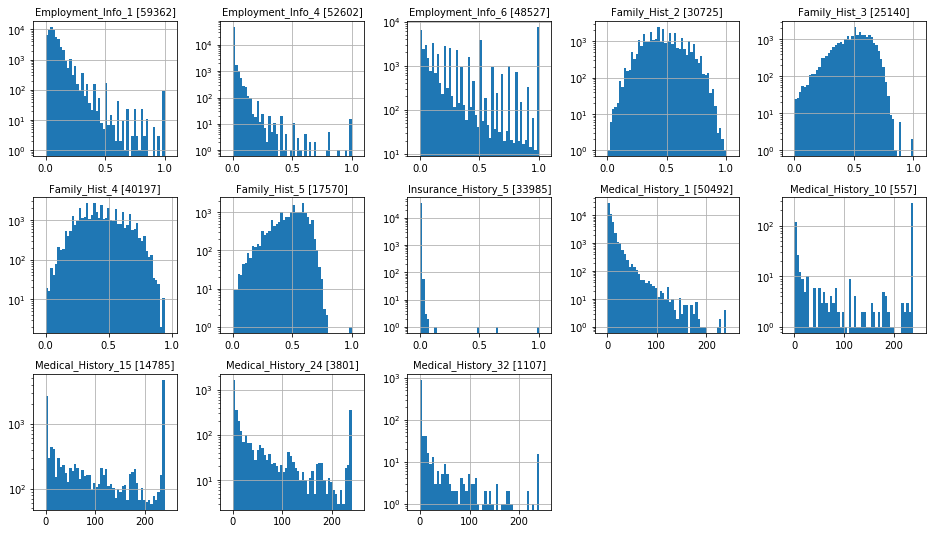

In [181]:
na_cols = list(missing_percent.iloc[:,0])
make_hist(train, na_cols, ylog=True)

In [182]:
a=data['Insurance_History_5'].describe()
a

count    45645.000000
mean         0.001710
std          0.006465
min          0.000000
25%          0.000400
50%          0.000933
75%          0.002000
max          1.000000
Name: Insurance_History_5, dtype: float64

fix missing values and drop columns

In [187]:
data['Employment_Info_1'].fillna(data['Employment_Info_1'].median(),inplace=True)
data['Employment_Info_4'].fillna(data['Employment_Info_4'].median(),inplace=True)
data['Employment_Info_6'].fillna(data['Employment_Info_6'].mean(),inplace=True)
data['Medical_History_1'].fillna(data['Medical_History_1'].median(),inplace=True)
data.drop('Insurance_History_5',axis=1,inplace=True)
data.drop(['Medical_History_10','Medical_History_15','Medical_History_24','Medical_History_32','Family_Hist_5'],axis=1,inplace=True)
data['Family_Hist_2'].fillna(data['Family_Hist_2'].mean(),inplace=True)
data['Family_Hist_3'].fillna(data['Family_Hist_3'].mean(),inplace=True)
data['Family_Hist_4'].fillna(data['Family_Hist_4'].mean(),inplace=True)
train = data[data['Response']>0].copy()
test = data[data['Response']<1].copy()
data.drop(['Response'], axis=1, inplace=True)

check the processing

In [ ]:
data.isnull().sum()

#feature engineering

In [189]:
data["BMI_Ins_age"] = data.BMI * data.Ins_Age

In [190]:
data["Product_Info_2_char"] = data.Product_Info_2.str[0]
data["Product_Info_2_num"] = data.Product_Info_2.str[1]
data['Product_Info_2'] = pd.factorize(data['Product_Info_2'])[0]
data['Product_Info_2_char']= pd.factorize(data['Product_Info_2_char'])[0]
data['Product_Info_2_num'] = pd.factorize(data['Product_Info_2_num'])[0]

In [ ]:
split data

In [191]:
X_df=data.iloc[0:59381]
X_test_df = data.iloc[59381:]
X = X_df.values



In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

Standard dataset

In [193]:
from sklearn.preprocessing import StandardScaler
sc_X= StandardScaler()
X_train= sc_X.fit_transform(X_train)
X_test= sc_X.transform(X_test)

Models and transform output for regressions

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from scipy.optimize import fmin_powell

def transform_output(y):
	return np.clip(np.round(y).astype('int32'), 1, 8)




In [297]:
from sklearn.linear_model import LinearRegression
classifierObj= LinearRegression()
classifierObj.fit(X_train, y_train)
y_pred= classifierObj.predict(X_test)
print('Linear Regression Testing kappa',quadratic_weighted_kappa(transform_output(y_pred),y_test))

0.5073738334761837


In [296]:
y_train_pred = classifierObj.predict(X_train)
print('Linear Regression Training kappa:',quadratic_weighted_kappa(transform_output(y_train_pred),y_train))

0.513617817169138


class weights count

In [214]:
from collections import Counter
weight = dict(Counter(y_train))
weight.values(),weight
w = [4341,4601,701,997,3801,7894,5631,13600]
p_w = [i/y_train.shape[0] for i in w]

In [282]:
weight

{7: 5631, 8: 13600, 2: 4601, 6: 7894, 4: 997, 5: 3801, 1: 4341, 3: 701}

In [195]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from ml_metrics import quadratic_weighted_kappa
from sklearn.preprocessing import PolynomialFeatures

Extend LinearRegression for pipeline

In [196]:
class LinearRegressionTransformer(LinearRegression, TransformerMixin):
	"""Extend LinearRegression so it can be used in non-final pipeline stage.
	"""	
	def transform(self, x):
		return self.predict(x)
p = Pipeline([
	('pca', PCA()),
    ('plf',PolynomialFeatures()),
	('reg', LinearRegressionTransformer())
	
])


p.fit(X_train, y_train)
y_train_predict = p.predict(X_train)




In [197]:
print("Training kappa", quadratic_weighted_kappa(y_train, transform_output(y_train_predict)))



Training kappa 0.6596832036701126


In [267]:
print('testing',quadratic_weighted_kappa(y_test,transform_output(p.predict(X_test))))

testing 0.5049230298706031


RandomForestClassifier Model

In [269]:
rl = RandomForestClassifier(random_state = 0, n_estimators = 100)
rl.fit(X_train,y_train)
print('Train kappa',quadratic_weighted_kappa(rl.predict(X_train),y_train))
print('Test kappa',quadratic_weighted_kappa(rl.predict(X_test),y_test))

Train kappa 1.0
Test kappa 0.47571496321514184


Dimension Reduction and SVC Model

In [233]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
params = {'dr__n_components':[80,90,100,110], 'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma':['auto'],
    'svc__decision_function_shape': ['ovo','ovr']
    
}
p2 = Pipeline([('dr', PCA()), ('svc',SVC())])
gd=GridSearchCV(estimator = p2, param_grid = params,scoring=make_scorer(quadratic_weighted_kappa), cv=5, n_jobs=-1)
gd.fit(X_train, y_train) 
print(gd.best_params_)  
print(gd.best_score_)
 

{'dr__n_components': 110, 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
0.5030943782130453


In [234]:
print(gd.cv_results_)

{'mean_fit_time': array([1387.56326036,  621.34171505,  623.2265882 ,  430.9816884 ,
       1380.21086473,  624.9510704 ,  621.83643064,  421.30977497,
       1671.25857987,  711.2702919 ,  691.01756206,  482.27878113,
       1626.8187232 ,  694.18947797,  657.9894845 ,  460.76015105,
       1849.26517839,  747.73337817,  732.0109169 ,  541.72846942,
       1856.59604187,  776.46644702,  716.25297756,  518.26182261,
       3779.63385692,  847.97337108,  749.47511806,  554.05319257,
       3194.30389557,  668.95709338,  563.01258826,  397.36587939]), 'std_fit_time': array([ 15.97662823,   6.36365212,   3.59139205,   7.88027564,
         7.03442945,   4.32858693,   4.82757439,   7.35267383,
        15.38907669,  12.58907262,  22.3514757 ,  14.18831638,
        19.41317713,  19.43526704,   7.79583224,   7.50581122,
        39.31701393,   8.40807259,  38.10381902,   5.91709347,
        36.69992452,  19.45264771,   7.14471052,   6.84208848,
       398.27601523,  13.02031439,  17.71910661,  

In [264]:
print('testing',quadratic_weighted_kappa(gd.predict(X_test),y_test))

testing 0.5032839838274523


 KNeighborsClassifier Model

In [210]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier

pk =KNeighborsClassifier(n_neighbors = 8)

grid_params_knn = {
                  'weights':['uniform','distance'],
                  'algorithm':['kd_tree','brute']}
gdk=GridSearchCV(estimator = pk, param_grid = grid_params_knn,scoring=make_scorer(quadratic_weighted_kappa), cv=5, n_jobs=-1)
gdk.fit(X_train, y_train) 
print(gdk.best_params_)  
print(gdk.best_score_)


{'algorithm': 'kd_tree', 'weights': 'uniform'}
0.4023744695307918


In [211]:
y_preds = gdk.predict(X_test)

In [216]:
print('Testing kappa:', quadratic_weighted_kappa(y_preds,y_test))

Testing kappa: 0.4044269909217205


In [213]:
print(gdk.cv_results_)

{'mean_fit_time': array([22.24957576, 24.25897613,  0.27434435,  0.2692862 ]), 'std_fit_time': array([3.57319823, 1.5741299 , 0.07197269, 0.03114614]), 'mean_score_time': array([181.01461358, 179.32542782,  25.57022862,  24.8279851 ]), 'std_score_time': array([1.44192881, 0.99141182, 2.96570979, 1.499888  ]), 'param_algorithm': masked_array(data=['kd_tree', 'kd_tree', 'brute', 'brute'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'algorithm': 'kd_tree', 'weights': 'uniform'}, {'algorithm': 'kd_tree', 'weights': 'distance'}, {'algorithm': 'brute', 'weights': 'uniform'}, {'algorithm': 'brute', 'weights': 'distance'}], 'split0_test_score': array([0.3882593 , 0.36764681, 0.3882593 , 0.36764681]), 'split1_test_score': array([0.40216487, 0.38390878,

In [ ]:
print(gdg.cv_results_)

Union PCA and LDA to see the result and DecisionTreeClassifier Model

In [232]:
from sklearn.tree import DecisionTreeClassifier
estimators = [('pca', PCA()), ('lda',(LDA()))]
combined = FeatureUnion(estimators)
p5 = Pipeline([('comb',combined),
              ('dtc',DecisionTreeClassifier())])

grid_params_dtc = {'comb__pca__n_components':[100,110,114],
                   'comb__lda__n_components':[100,110,114],
                  'dtc__criterion':['gini','entropy'],
                  'dtc__class_weight':['balanced',None]}
gdd=GridSearchCV(estimator = p5, param_grid = grid_params_dtc,scoring=make_scorer(quadratic_weighted_kappa), cv=5, n_jobs=-1)
gdd.fit(X_train, y_train) 
print(gdd.best_params_)  
print(gdd.best_score_)


D:\Users\admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(114, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
D:\Users\admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


{'comb__lda__n_components': 110, 'comb__pca__n_components': 100, 'dtc__class_weight': None, 'dtc__criterion': 'gini'}
0.3728560462715928


In [263]:
print(gdd.cv_results_)
print('Testing kappa',quadratic_weighted_kappa(gdd.predict(X_test),y_test))

{'mean_fit_time': array([15.86244135, 34.09437089, 14.35962019, 32.17091322, 13.97316356,
       34.43479166, 15.03182974, 34.36602488, 14.32639976, 35.34332094,
       15.27596507, 35.67189488, 12.88062272, 31.38850417, 13.00123153,
       31.46417418, 14.04823594, 34.12616448, 14.50568857, 34.68100572,
       14.31694164, 35.33755817, 15.01941423, 35.57175736, 12.96033683,
       31.59649029, 13.14395022, 31.40751734, 13.88419619, 34.05035639,
       14.44372959, 34.45451074, 14.69865699, 34.45870318, 15.61299233,
       24.73461657]), 'std_fit_time': array([0.30318455, 0.59787939, 1.54340155, 0.49048897, 0.37472078,
       0.71823916, 0.33530244, 0.94256879, 0.23295233, 0.64086609,
       0.27564528, 0.78545971, 0.16786021, 0.21712804, 0.23514601,
       0.45168685, 0.47600707, 0.42861201, 0.4069846 , 0.32606425,
       0.2014187 , 0.60994942, 0.19196049, 0.47836186, 0.22140438,
       0.61286465, 0.21494224, 0.33511293, 0.45649976, 0.71705765,
       0.44821773, 0.78022466, 0.43616

Hyperparameters Tuning for LogisticRegresssion

In [ ]:
grid_param1= {  'penalty': ['l2'],'solver': ['newton-cg', 'sag','lbfgs'],'class_weight' : ['balanced',None]}
grid_param2 = {'penalty':['l1'],'solver':['liblinear','saga'],'class_weight' : ['balanced',None],'l1_ratio': [0.001,0.01,0.1,1]}
grid_param3 = {'penalty': ['elasticnet'],'solver':['saga'],'l1_ratio': [0.001,0.01,0.1,1]}
grid_params = [grid_param1,grid_param2,grid_param3]

 
lrclassifierObj= LogisticRegression(multi_class = 'auto',random_state=0)
for grid_param in grid_params:
    gd_sr= GridSearchCV(estimator=lrclassifierObj, param_grid=grid_param, scoring=make_scorer(quadratic_weighted_kappa), refit= True,cv=5, n_jobs=-1)
    gd_sr.fit(X_train, y_train) 
    print(gd_sr.best_params_)  
    print(gd_sr.best_score_)
    print(gd_sr.cv_results_)

Picked out parameters for LogisticeRegression and see the scores

In [262]:
l = LogisticRegression(class_weight='balanced', penalty= 'l2', solver= 'newton-cg',multi_class = 'auto')
l.fit(X_train,y_train)
y_lr_preds=l.predict(X_test)
print('Training kappa',quadratic_weighted_kappa(l.predict(X_train),y_train))
print('Testing kappa',quadratic_weighted_kappa(y_lr_preds,y_test))

Training kappa 0.49147890868683874
Testing kappa 0.4836260066650545


Build ensemble model

In [255]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
clf1 = LogisticRegression(class_weight='balanced', penalty= 'l2', solver= 'newton-cg',multi_class = 'auto')
clf2 = DecisionTreeClassifier(criterion= 'gini')
clf3 = RandomForestClassifier(random_state=1, n_estimators=100)
clf4 = SVC(decision_function_shape= 'ovo', gamma= 'auto', kernel= 'rbf',probability = True)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('rf', clf3), ('svc',clf4)],voting='hard')
eclf1 = eclf1.fit(X_train, y_train)


In [256]:
y_train_preds = eclf1.predict(X_train)
y_test_preds = eclf1.predict(X_test)


In [257]:
print('Training kappa',quadratic_weighted_kappa(y_train_preds,y_train))
print('Testing kappa',quadratic_weighted_kappa(y_test_preds,y_test))

Training kappa 0.9715787391032532
Testing kappa 0.5159502122305824


Second ensemble model - XGBoost

In [270]:
import xgboost as xgb
from scipy.optimize import fmin_powell
from ml_metrics import quadratic_weighted_kappa
from sklearn.model_selection import train_test_split
def xgb_all(X_train,X_test, y_train,y_test):
    def eval_wrapper(yhat, y):  
        y = np.array(y)
        y = y.astype(int)
        yhat = np.array(yhat)
        yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
        return quadratic_weighted_kappa(yhat, y)
    def get_params():
        
        params = {}
        params["objective"] = "reg:linear"     
        params["eta"] = 0.05
        params["min_child_weight"] = 360
        params["subsample"] = 0.85
        params["colsample_bytree"] = 0.3
        params["silent"] = 1
        params["max_depth"] = 7
        plst = list(params.items())
    
        return plst
    def get_params2():
        params = {}
        params["objective"] = "reg:linear"     #count:poisson reg:linear
        params["n_estimators "] = 1000
        params["max_child_weight"] = 1
        params["gamma"] = 0
        params["subsample"] = 0.8
        params["learning_rate"] = 0.1
        params["colsample_bytree"] = 0.8
        params["nthread"] = 4
        params["scale_pos_weight"] = 1
        params["max_depth"] = 7
        params["seed"] = 26
        plst = list(params.items())
        
        return plst
    def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
        # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
        data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
        score = scorer(data[1], data[2])
        return score
        
    def apply_offsets(data, offsets):
        for j in range(num_classes):
            data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
        return data
    
    def offset_apply(train_preds, test_preds, y):
    
        train_preds = np.clip(train_preds, -0.99, 8.99)
        test_preds = np.clip(test_preds, -0.99, 8.99)
    
        offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
    
        offset_preds = np.vstack((train_preds, train_preds, y))
        offset_preds = apply_offset(offset_preds, offsets)
    
        opt_order = list(range(8))
        for j in opt_order:
            train_offset = lambda x: -score_offset(offset_preds, x, j) * 100
            offsets[j] = fmin_powell(train_offset, offsets[j], disp=True)
    
        train_offset_out = np.vstack((train_preds, train_preds))
        train_offset_out = apply_offset((train_preds, offsets))
        final_train_preds = np.round(np.clip(train_offset_out[1], 1, 8)).astype(int)
        test_offset = np.vstack((test_preds, test_preds))
        test_offset = apply_offset(test_offset, offsets)
        final_test_preds = np.round(np.clip(test_offset[1], 1, 8)).astype(int)
    
        return final_train_preds, final_test_preds 
    
    xgb_num_rounds = 720
    num_classes = 8
    #missing_indicator = -1000
    
    xgtrain = xgb.DMatrix(X_train, y_train, 
                            #missing=missing_indicator
                         )
    xgtest = xgb.DMatrix(X_test, label=y_test, 
                           # missing=missing_indicator
                        )    
    # get the parameters for xgboost
    plst = get_params()
    print(plst)      
    
    # train model
    model = xgb.train(plst, xgtrain, xgb_num_rounds) 
    
    train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
    #print('Train score is:', eval_wrapper(train_preds, y_train)) 
    train_score = eval_wrapper(train_preds, y_train)
    test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
   #print('Test score is:', eval_wrapper(test_preds,y_test))
    test_score = eval_wrapper(test_preds,y_test)
    # train offsets
    
    offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
    offset_train_preds = np.vstack((train_preds, train_preds, y_train))
    offset_train_preds = apply_offsets(offset_train_preds, offsets)
    
    opt_order = [6,4,5,3]
    for j in opt_order:
        train_offset = lambda x: -score_offset(offset_train_preds, x, j) * 100
        offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)
    
    #print('Offset Train score is:', eval_wrapper(offset_train_preds[1], y_train)) 
    offset_train_score = eval_wrapper(offset_train_preds[1], y_train)
    # apply offsets to test
    offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
    offset_test_preds = np.vstack((test_preds, test_preds, y_test))
    offset_test_preds = apply_offsets(offset_test_preds, offsets)   
    opt_order = [6,4,5,3]
    for j in opt_order:
        test_offset = lambda x: -score_offset(offset_test_preds, x, j) * 100
        offsets[j] = fmin_powell(test_offset, offsets[j], disp=False)
    offset_test_score = eval_wrapper(offset_test_preds[1],y_test) 
    return train_score,test_score, offset_train_score,offset_test_score 
   

In [271]:
train_score, test_score, offset_train_score, offset_test_score = xgb_all(X_train,X_test,y_train,y_test)
print('Training kappa', train_score)
print('Testing kappa', test_score)
print('offset Training kappa', offset_train_score)
print('offset Testing kappa', offset_test_score)

[('objective', 'reg:linear'), ('eta', 0.05), ('min_child_weight', 360), ('subsample', 0.85), ('colsample_bytree', 0.3), ('silent', 1), ('max_depth', 7)]
Training kappa 0.6178146296719287
Testing kappa 0.5582999083925873
offset Training kappa 0.6787756145726762
offset Testing kappa 0.6144222897993827
